# This notebook examines the relative magntidue of horizontal mixing in the native TXLA parent model subsetted to the location of the nested grid

In [1]:
#Packages 
import numpy as np
import xgcm
from xgcm import Grid
import xarray as xr
import xroms
from datetime import datetime

import glob
from xhistogram.xarray import histogram
import cmocean.cm as cmo
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import ticker
from matplotlib.dates import DateFormatter
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams.update({'font.size': 11})
import matplotlib.dates as mdates
import pandas as pd

#Dask
from dask.distributed import Client

client = Client()
client

distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-w75ek7v6', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-6x5ao30w', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-nrcsv2_k', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-tlewpugd', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-mbvsc29y', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES/analysis_notebooks/dask-worker-space/worker-v41og8sj', purging
distributed.diskutils - INFO - Found stale lock file and directory '/d2/home/dylan/JAMES

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 62.65 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:42982,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 62.65 GiB
Comm: tcp://127.0.0.1:41629,Total threads: 4
Dashboard: http://127.0.0.1:37773/status,Memory: 7.83 GiB
Nanny: tcp://127.0.0.1:45763,


# Open model output with xroms

In [2]:
path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver0/ocean_avg_0000*.nc')
ds_avg = xroms.open_mfnetcdf(path)
ds_avg, grid_avg = xroms.roms_dataset(ds_avg)

path = glob.glob('/d1/shared/TXLA_ROMS/numerical_mixing/non-nest/ver0/ocean_dia_0000*.nc')
ds_dia = xr.open_mfdataset(path)
xislice = slice(271,404)
etaslice = slice(31,149)

# Compute the volume integrated horizontal and vertical salt diffusion and save to a netcdf for plotting. Will take some time for this to run. 
## $h_{diffusion} = \iiint_V \frac{\partial}{\partial x} \big(K_h \frac{\partial s}{\partial x} \big)+ \, \frac{\partial}{\partial y} \big(K_h \frac{\partial s}{\partial y} \big) dV$
## $v_{diffusion} = \iiint_V \frac{\partial}{\partial z} \big(K_v \frac{\partial s}{\partial z} \big) \, dV$
### The diagnostic file outputs both horizontal and vertical diffusion on a per cell basis, so all we need to do is volume integrate. Unfortunately, it does not output the horizontal eddy diffusivity needed to compute the horizontal mixing component explicity. However, $\chi = \iiint_v $

In [54]:
salt_vdiffusion = (ds_dia.salt_vdiff*ds_avg.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['eta_rho', 'xi_rho', 's_rho'])
salt_vdiffusion.attrs = ''
salt_hdiffusion = (ds_dia.salt_hdiff*ds_avg.dV).isel(eta_rho = etaslice, xi_rho = xislice).sum(['eta_rho', 'xi_rho', 's_rho'])
salt_hdiffusion.attrs = ''

print('saving outputs')
dates = np.arange('2010-06-03', '2010-07-14', dtype = 'datetime64[D]') 
for d in range(len(dates)):
    salt_vdiffusion_sel = salt_vdiffusion.sel(ocean_time = str(dates[d]))
    path = '/d2/home/dylan/JAMES/budget_outputs/diffusion/salt_vdiffusion_parent_2010_%s.nc' %d
    salt_vdiffusion_sel.name = 'salt_vdiffusion'
    salt_vdiffusion_sel.to_netcdf(path, mode = 'w')
    
    salt_hdiffusion_sel = salt_hdiffusion.sel(ocean_time = str(dates[d]))
    path = '/d2/home/dylan/JAMES/budget_outputs/diffusion/salt_hdiffusion_parent_2010_%s.nc' %d
    salt_hdiffusion_sel.name = 'salt_hdiffusion'
    salt_hdiffusion_sel.to_netcdf(path, mode = 'w')

saving outputs


distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.62 GiB -- Worker memory limit: 7.83 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.68 GiB -- Worker memory limit: 7.83 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker.html#memtrim for more information. -- Unmanaged memory: 5.54 GiB -- Worker memory limit: 7.83 GiB
distributed.worker - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see 

In [56]:
vdiffusion = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/diffusion/salt_vdiffusion_parent_2010_*.nc').salt_vdiffusion
hdiffusion = xr.open_mfdataset('/d2/home/dylan/JAMES/budget_outputs/diffusion/salt_hdiffusion_parent_2010_*.nc').salt_hdiffusion

Text(0, 0.5, '[(g kg$^{-1}$) m$^3$ s$^{-1}$]')

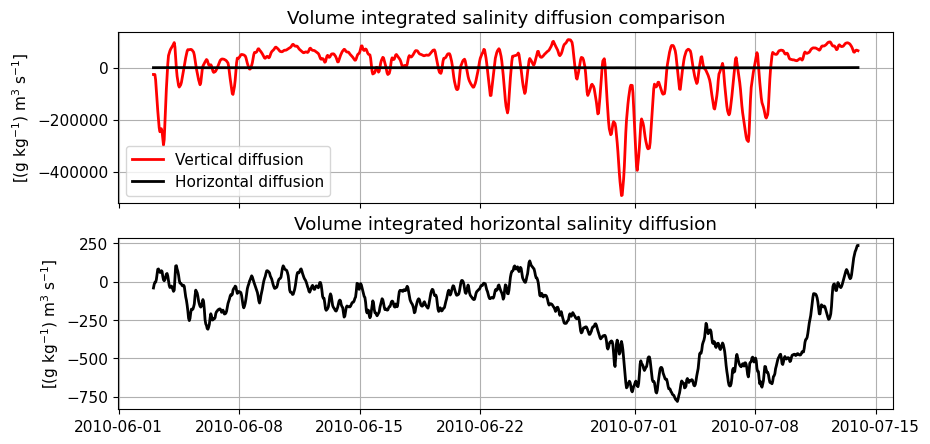

In [65]:
fig, ax = plt.subplots(2, figsize = (10,5), dpi = 100)

ax[0].plot(vdiffusion.ocean_time, vdiffusion, color = 'r', lw = 2, label = 'Vertical diffusion')
ax[0].plot(hdiffusion.ocean_time, hdiffusion, color = 'k', lw = 2, label = 'Horizontal diffusion')

ax[0].legend()
ax[0].grid()
ax[0].set_xticklabels([])
ax[0].set_title('Volume integrated salinity diffusion comparison')
ax[0].set_ylabel(r'[(g kg$^{-1}$) m$^3$ s$^{-1}$]')

ax[1].plot(hdiffusion.ocean_time, hdiffusion, color = 'k', lw = 2, label = 'Horizontal diffusion')
ax[1].grid()
ax[1].set_title('Volume integrated horizontal salinity diffusion')
ax[1].set_ylabel(r'[(g kg$^{-1}$) m$^3$ s$^{-1}$]')

# Source code if you want to look at K_h separately:

# ifdef TS_DIF2
      DO itrc=1,NT(ng)
        cff=diffusion2(itrc)/grdmax(ng)
        DO j=JstrT,JendT
          DO i=IstrT,IendT
            diff2(i,j,itrc)=cff*grdscl(i,j)
          END DO
        END DO
      END DO
# endif